In [2]:
import os
import glob
import shutil

# Setting logging level
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or '3' to additionally suppress all warnings

In [41]:
# Define the path to your dataset
dataset_path = "../dataset/MMAFEDB/train/"

# Define the emotions and their respective folders
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Loop through each emotion and remove all files containing '_augmented_'
for emotion in emotions:
    emotion_path = os.path.join(dataset_path, emotion)

    # Get a list of all files containing '_augmented_' in the emotion folder
    files_to_remove = glob.glob(os.path.join(emotion_path, '*_augmented_*'))

    # Remove each file
    for file_path in files_to_remove:
        os.remove(file_path)

    print(f'{emotion}: All files containing "_augmented_" removed successfully.')

    # Check if 'archive_images_emotion' folder is present
    archive_emotion_folder_path = os.path.join(dataset_path, 'archive_images_' + emotion)
    if os.path.exists(archive_emotion_folder_path):
        # Move contents of 'archive_images_emotion' to the emotion folder
        files_in_archive_emotion = glob.glob(os.path.join(archive_emotion_folder_path, '*'))
        for file_in_archive_emotion in files_in_archive_emotion:
            destination_path = os.path.join(emotion_path, os.path.basename(file_in_archive_emotion))
            shutil.move(file_in_archive_emotion, destination_path)

        # Remove 'archive_images_emotion' folder
        os.rmdir(archive_emotion_folder_path)
        print(f'{emotion}: Contents of "archive_images_{emotion}" moved to parent folder and folder deleted.')

print("Cleanup completed.")


angry: All files containing "_augmented_" removed successfully.
disgust: All files containing "_augmented_" removed successfully.
fear: All files containing "_augmented_" removed successfully.
happy: All files containing "_augmented_" removed successfully.
happy: Contents of "archive_images_happy" moved to parent folder and folder deleted.
neutral: All files containing "_augmented_" removed successfully.
neutral: Contents of "archive_images_neutral" moved to parent folder and folder deleted.
sad: All files containing "_augmented_" removed successfully.
sad: Contents of "archive_images_sad" moved to parent folder and folder deleted.
surprise: All files containing "_augmented_" removed successfully.
Cleanup completed.


In [42]:
from keras.preprocessing.image import ImageDataGenerator
import os
import glob
import pandas as pd

# Define the path to your dataset
dataset_path = "../dataset/MMAFEDB/train/"

# Define the emotions and their respective folders
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Specify the minimum number of images you want in each class after augmentation
min_images_per_class = 10000

# Create a DataFrame to store the image file paths and their corresponding labels
data = {'file_path': [], 'emotion': []}

for emotion in emotions:
    emotion_path = os.path.join(dataset_path, emotion)
    image_paths = glob.glob(os.path.join(emotion_path, '*.jpg'))
    data['file_path'].extend(image_paths)
    data['emotion'].extend([emotion] * len(image_paths))

df = pd.DataFrame(data)

# Dictionary to store the count of augmented images per emotion
augmented_count = {}

for emotion in emotions:
    augmented_count[emotion] = 0

# Create an ImageDataGenerator with your desired augmentation settings
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Loop through each emotion and perform augmentation
for emotion in emotions:
    # Filter the DataFrame to include only the current emotion
    subset_df = df[df['emotion'] == emotion]

    # Exclude previously augmented images from the DataFrame
    subset_df = subset_df[~subset_df['file_path'].str.contains('_augmented')]

    # Calculate the number of augmentations needed
    augmentations_needed = max(0, min_images_per_class - len(subset_df))

    # Create a flow_from_dataframe generator
    generator = datagen.flow_from_dataframe(
        subset_df,
        directory=None,  # We provide the full file paths in 'file_path' column
        x_col='file_path',
        y_col='emotion',
        target_size=(48, 48),
        batch_size=1,
        class_mode='categorical',
        save_to_dir=os.path.join(dataset_path, emotion),
        save_prefix=emotion + '_augmented',
        save_format='jpg'
    )

    # Generate augmented images only if augmentations are needed
    if augmentations_needed > 0:
        for i in range(augmentations_needed):
            batch = generator.next()

        # Get the count of augmented images generated
        augmented_count[emotion] = i + 1

        print(f'{emotion}: {augmented_count[emotion]} augmented images generated successfully.\n')
    else:
        print(f'{emotion}: 0 augmented images generated. No augmentations needed.\n')

# Print the total count of augmented images per emotion
print("\nTotal Augmented Images per Emotion:")
for emotion, count in augmented_count.items():
    print(f'{emotion}: {count}')


Found 6566 validated image filenames belonging to 1 classes.
angry: 3434 augmented images generated successfully.

Found 3231 validated image filenames belonging to 1 classes.
disgust: 6769 augmented images generated successfully.

Found 4859 validated image filenames belonging to 1 classes.
fear: 5141 augmented images generated successfully.

Found 28592 validated image filenames belonging to 1 classes.
happy: 0 augmented images generated. No augmentations needed.

Found 29384 validated image filenames belonging to 1 classes.
neutral: 0 augmented images generated. No augmentations needed.

Found 12223 validated image filenames belonging to 1 classes.
sad: 0 augmented images generated. No augmentations needed.

Found 8113 validated image filenames belonging to 1 classes.
surprise: 1887 augmented images generated successfully.


Total Augmented Images per Emotion:
angry: 3434
disgust: 6769
fear: 5141
happy: 0
neutral: 0
sad: 0
surprise: 1887


###########################
Folder: ../dataset/MMAFEDB/train/
Total Images: 110199

Count per emotion:
neutral: 29384
angry: 10000
fear: 10000
happy: 28592
disgust: 10000
sad: 12223
surprise: 10000

Count of Augmented Images per Emotion:
angry: 3434
fear: 5141
disgust: 6769
surprise: 1887


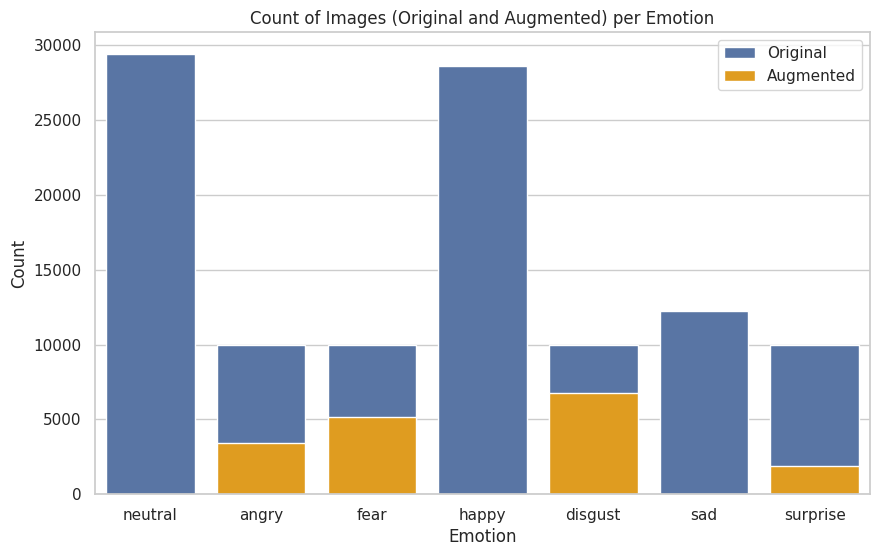

In [43]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Define the path to your dataset
dataset_path = "../dataset/MMAFEDB/train/"

def summarize_images(folder, show_size_only=False):
    total_images = 0
    emotion_counts = {}
    augmented_counts = {}
    archive_folder_name = 'archive_images'

    for root, dirs, files in os.walk(folder):
        # Exclude 'archive_images' folders from processing
        dirs = [d for d in dirs if not d.startswith(archive_folder_name)]

        for file in files:
            if file.endswith(".jpg"):
                file_path = os.path.join(root, file)

                # Extract emotion from the path
                emotion = os.path.basename(os.path.dirname(file_path))

                total_images += 1

                # Skip 'archive_images' folders
                if emotion.startswith(archive_folder_name):
                    continue

                # Count per emotion
                if emotion in emotion_counts:
                    emotion_counts[emotion] += 1
                else:
                    emotion_counts[emotion] = 1

                # Count augmented images per emotion
                if "_augmented_" in file:
                    if emotion in augmented_counts:
                        augmented_counts[emotion] += 1
                    else:
                        augmented_counts[emotion] = 1

    print('###########################')
    print(f"Folder: {folder}")
    print(f"Total Images: {total_images}")

    print("\nCount per emotion:")
    for emotion, count in emotion_counts.items():
        print(f"{emotion}: {count}")

    print("\nCount of Augmented Images per Emotion:")
    for emotion, count in augmented_counts.items():
        print(f"{emotion}: {count}")

    # Plotting the stacked bar count using Seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(emotion_counts.keys()), y=list(emotion_counts.values()), label="Original")
    sns.barplot(x=list(augmented_counts.keys()), y=list(augmented_counts.values()), label="Augmented", color='orange')
    plt.title("Count of Images (Original and Augmented) per Emotion")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

    return {
        "total_images": total_images,
        "emotion_counts": emotion_counts,
        "augmented_counts": augmented_counts
    }

# Summarize images in the train folder
summary_train_dir = summarize_images(dataset_path)


In [44]:
import os
import shutil

def move_smallest_to_archive_per_emotion(folder, target_count=10000):
    emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    archive_folder_name = 'archive_images'

    for emotion in emotions:
        emotion_folder = os.path.join(folder, emotion)

        # Check if the emotion folder exists
        if os.path.exists(emotion_folder):
            # List files in the emotion folder, sorted by size
            files_sorted_by_size = sorted(os.listdir(emotion_folder), key=lambda x: os.path.getsize(os.path.join(emotion_folder, x)))

            # Check if the emotion folder exceeds the target count
            count_to_move = max(0, len(files_sorted_by_size) - target_count)

            if count_to_move > 0:
                # Create 'archive_images_emotion' folder inside the parent folder if it doesn't exist
                archive_emotion_folder = os.path.join(folder, f"{archive_folder_name}_{emotion}")
                if not os.path.exists(archive_emotion_folder):
                    os.makedirs(archive_emotion_folder)

                # Move files to 'archive_images_emotion' folder
                for file_to_move in files_sorted_by_size[:count_to_move]:
                    source_path = os.path.join(emotion_folder, file_to_move)
                    destination_path = os.path.join(archive_emotion_folder, file_to_move)
                    shutil.move(source_path, destination_path)

                print(f"Moved {count_to_move} smallest files to '{archive_folder_name}_{emotion}' folder.")
            else:
                print(f"No files moved in '{emotion}' emotion folder as the count is within the target.")

        else:
            print(f"'{emotion}' emotion folder not found.")

# Example usage
move_smallest_to_archive_per_emotion(dataset_path)

No files moved in 'angry' emotion folder as the count is within the target.
No files moved in 'disgust' emotion folder as the count is within the target.
No files moved in 'fear' emotion folder as the count is within the target.
Moved 18592 smallest files to 'archive_images_happy' folder.
Moved 19384 smallest files to 'archive_images_neutral' folder.
Moved 2223 smallest files to 'archive_images_sad' folder.
No files moved in 'surprise' emotion folder as the count is within the target.


###########################
Folder: ../dataset/MMAFEDB/train/
Total Images: 110199

Count per emotion:
neutral: 10000
angry: 10000
fear: 10000
happy: 10000
disgust: 10000
sad: 10000
surprise: 10000

Count of Augmented Images per Emotion:
angry: 3434
fear: 5141
disgust: 6769
surprise: 1887


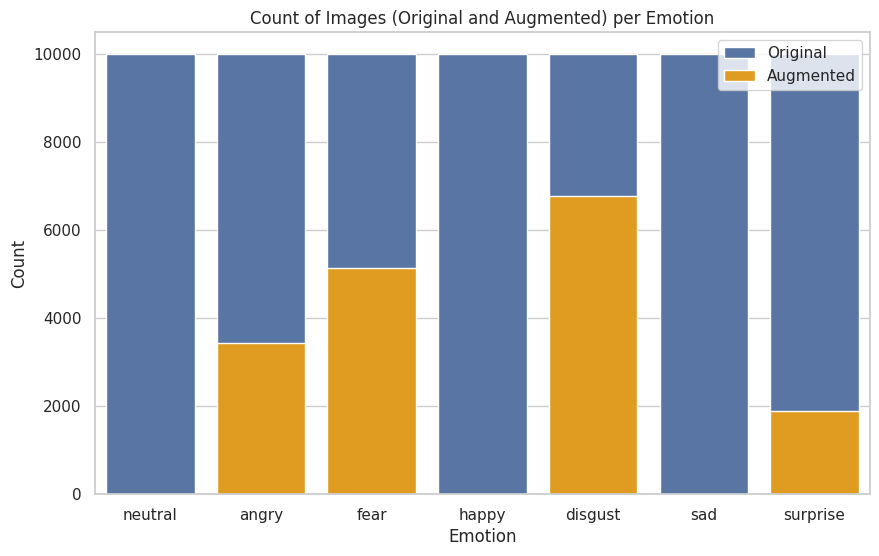

In [45]:
# Summarize images in the train folder
summary_train_dir = summarize_images(dataset_path)

In [3]:
# Retraining the best model that was found with balanced dataset

## Best peforming model based on validation accuracy is model_2_best_sgd_rgb_128_augment
best_model_name = 'model_2_best_sgd_rgb_128'

import os
import json

# Recreate the exact same model, including its weights and the optimizer
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import scikitplot as skplt


# Due to file upload limitation the ckpt file is now loaded with json_file model architecture and weights.
# Load architecture from JSON file
with open("../models/best_model/best_model_architecture.json", "r") as json_file:
    loaded_model_json = json_file.read()

keras_best_model = tf.keras.models.model_from_json(loaded_model_json)

# Image Specifications
folder_path = "../dataset/MMAFEDB/"
image_dimension = (48, 48)
image_color_mode = 'rgb'
batch_size = 128

# Define the list of classes (emotions)
classes = ['angry','disgust','fear','happy','neutral','sad','surprise']

# Create validation image generator and normalize images
datagen = ImageDataGenerator(
    rescale=1./255
)

# Flow from directory to load the images into the pipeline
train_set = datagen.flow_from_directory(
    folder_path + "train",
    target_size=image_dimension,
    color_mode=image_color_mode,
    class_mode='categorical',
    classes=classes,
    shuffle=True,
    batch_size=batch_size
)

test_set = datagen.flow_from_directory(
    folder_path + "test",
    target_size=image_dimension,
    color_mode=image_color_mode,
    class_mode='categorical',
    classes=classes,
    shuffle=False,
    batch_size=1
)

# Get the total number of images in the training set
total_images_train = train_set.n
print("Total images in training set:", total_images_train)
# Get the total number of images in the test set
total_images_test = test_set.n
print("Total images in test set:", total_images_test)

Found 210000 images belonging to 7 classes.
Found 17326 images belonging to 7 classes.
Total images in training set: 210000
Total images in test set: 17326


In [4]:
## TRANING USING BALANCED EMOTION DATASET! 10,000 Images per emotion class = 70,000 total
# Best model parameters
augment = 'balanced'
optimizer = {
            'adam': tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
            'rmsprop': tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9),
            'sgd': tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
        }
loss = 'categorical_crossentropy'
metrics = ['accuracy']
selected_optimizer = 'sgd'

keras_best_model.compile(
            optimizer=optimizer[selected_optimizer],
            loss=loss,
            metrics=metrics
        )
keras_best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 46, 46, 32)        896       
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_2 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                      

Trainable params: 14255495 (54.38 MB)
Non-trainable params: 5824 (22.75 KB)
_________________________________________________________________


In [8]:
# Start model training!
# Define hyperparameters
# best_model_name = 'model_2_best_sgd_rgb_128'
folder_path_models = "../models/"
checkpoint_filename = folder_path_models+f"training/checkpoint/{best_model_name}_{augment}_cpt.h5"
epochs = 50
monitor='val_accuracy'
mode='max'

# Set up model checkpoint
print('\nSetting up checkpoint file for incremental validation accuracy improvements')
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filename,
    monitor=monitor,
    verbose=1,
    save_best_only=True,
    mode=mode
)
callbacks_list = [checkpoint]

# Train the model
print(f'********************** Model training started! ********************')
history = keras_best_model.fit(
    train_set,
    validation_data=test_set,
    steps_per_epoch=total_images_train // batch_size,
    validation_steps=total_images_test // batch_size,
    epochs=epochs,
    callbacks=callbacks_list
)
print(f'********************** Model training finished! ********************')

# Saving final model after train epochs have completed
final_filename = folder_path_models+f"training/final/{best_model_name}_{augment}_final.h5"
print(f'Saving final model to {final_filename}')
keras_best_model.save_weights(final_filename)

# Saving training history to file
history_filename = folder_path_models+f"training/history/{best_model_name}_{augment}_history.json"
with open(history_filename, 'w') as history_file:
    json.dump(history.history, history_file)
    print(f'Saved model.fit training history to {history_filename}')

# End of training loop!
print('########################################################################################')
print('##################### Loop has finished for current model file! ########################')
print('########################################################################################')


Setting up checkpoint file for incremental validation accuracy improvements
********************** Model training started! ********************
Epoch 1/50


2024-02-04 21:42:57.288450: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


546/546 [==============================] - ETA: 0s - loss: 2.3548 - accuracy: 0.3119
Epoch 1: val_accuracy improved from -inf to 0.02222, saving model to ../models/training/checkpoint/model_2_best_sgd_rgb_128_balanced_cpt.h5


/home/fox/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


546/546 [==============================] - 38s 58ms/step - loss: 2.3548 - accuracy: 0.3119 - val_loss: 2.5791 - val_accuracy: 0.0222
Epoch 2/50
546/546 [==============================] - ETA: 0s - loss: 2.4439 - accuracy: 0.3444
Epoch 2: val_accuracy did not improve from 0.02222
546/546 [==============================] - 30s 55ms/step - loss: 2.4439 - accuracy: 0.3444 - val_loss: 3.2964 - val_accuracy: 0.0000e+00
Epoch 3/50
546/546 [==============================] - ETA: 0s - loss: 2.5194 - accuracy: 0.3260
Epoch 3: val_accuracy improved from 0.02222 to 0.39259, saving model to ../models/training/checkpoint/model_2_best_sgd_rgb_128_balanced_cpt.h5
546/546 [==============================] - 30s 55ms/step - loss: 2.5194 - accuracy: 0.3260 - val_loss: 1.5343 - val_accuracy: 0.3926
Epoch 4/50
545/546 [============================>.] - ETA: 0s - loss: 2.4966 - accuracy: 0.3387
Epoch 4: val_accuracy did not improve from 0.39259
546/546 [==============================] - 30s 54ms/step - loss:

In [5]:
# Loading weights from above trained model (so we don't have to rerun training!)
# The weights saved above have been moved to the directory that is used below and renamed.
keras_best_model.load_weights('../models/best_model/best_weights_balanced_dataset.h5')

17326/17326 [==============================] - 40s 2ms/step


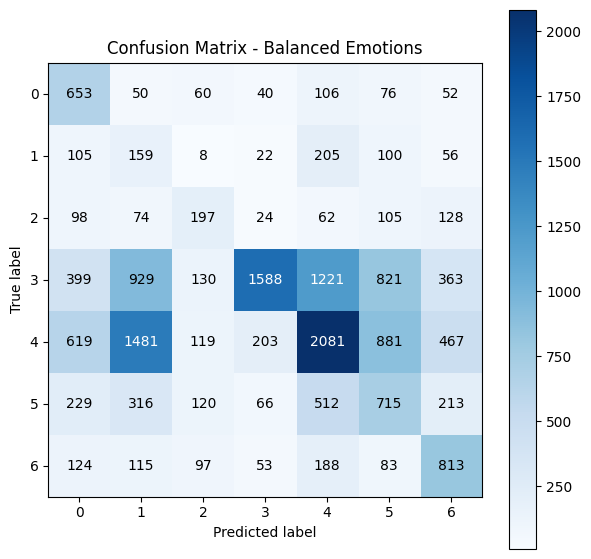

Number of wrong validation predictions: 11120
              precision    recall  f1-score   support

           0       0.29      0.63      0.40      1037
           1       0.05      0.24      0.08       655
           2       0.27      0.29      0.28       688
           3       0.80      0.29      0.43      5451
           4       0.48      0.36      0.41      5851
           5       0.26      0.33      0.29      2171
           6       0.39      0.55      0.46      1473

    accuracy                           0.36     17326
   macro avg       0.36      0.38      0.33     17326
weighted avg       0.51      0.36      0.38     17326

Label-encodings:  {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}


In [11]:
# Label encodings
labels = {
    0: "anger",
    1: "disgust",
    2: "fear",
    3: "happiness",
    4: "sadness",
    5: "surprise",
    6: "neutral",
}

# Load the true labels from the test set, important to have shuffle set to False!
y_test = test_set.classes

# Predict probabilities for each class using the model
y_pred_prob = keras_best_model.predict(test_set)    

# Get predicted classes
y_pred = np.argmax(y_pred_prob, axis=1)

# Now we have the predicted and actual label encodings the confusion matrix can be created
# Plot confusion matrix
skplt.metrics.plot_confusion_matrix(
    y_test,
    y_pred,
    figsize=(7, 7),
    title='Confusion Matrix - Balanced Emotions',
    cmap='Blues'
)
plt.savefig("../images/confusion_matrix_best_model_balanced_emotions.png")
plt.show()

incorrect_predictions = np.sum(y_test != y_pred)

# Display total wrong validation predictions
print(f"Number of wrong validation predictions: {incorrect_predictions}")

# Display classification report with zero_division parameter
print(classification_report(
    y_test,
    y_pred,
    zero_division=1  # Set to 1 or 'warn' or any numeric value you prefer
))

print('Label-encodings: ',labels)

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

with open('../models/training/history/model_2_best_sgd_rgb_128_balanced_history.json','r') as file:
    data = json.load(file)

model_name = 'model_2_best_sgd_rgb_128_balanced'

# Create the DataFrame directly
df = pd.DataFrame({
    'epoch': range(1,51), 
    'loss':data['loss'], 
    'accuracy':data['accuracy'], 
    'val_loss':data['val_loss'],
    'val_accuracy':data['val_accuracy']
})

df.index = df['epoch']
df.drop(columns='epoch',inplace=True)

# Display the DataFrame
print(f'{model_name}:\n',df.tail(10))

model_2_best_sgd_rgb_128_balanced:
            loss  accuracy  val_loss  val_accuracy
epoch                                            
41     0.648220  0.756684  1.359358      0.577778
42     0.627612  0.763868  1.351202      0.570370
43     0.608321  0.772513  1.456004      0.570370
44     0.590746  0.779311  1.439542      0.600000
45     0.574402  0.783647  1.508570      0.540741
46     0.566655  0.787468  1.557024      0.570370
47     0.547313  0.796442  1.166139      0.659259
48     0.542068  0.798260  1.898086      0.481481
49     0.530037  0.803212  1.260979      0.629630
50     0.500928  0.812099  1.378000      0.607407


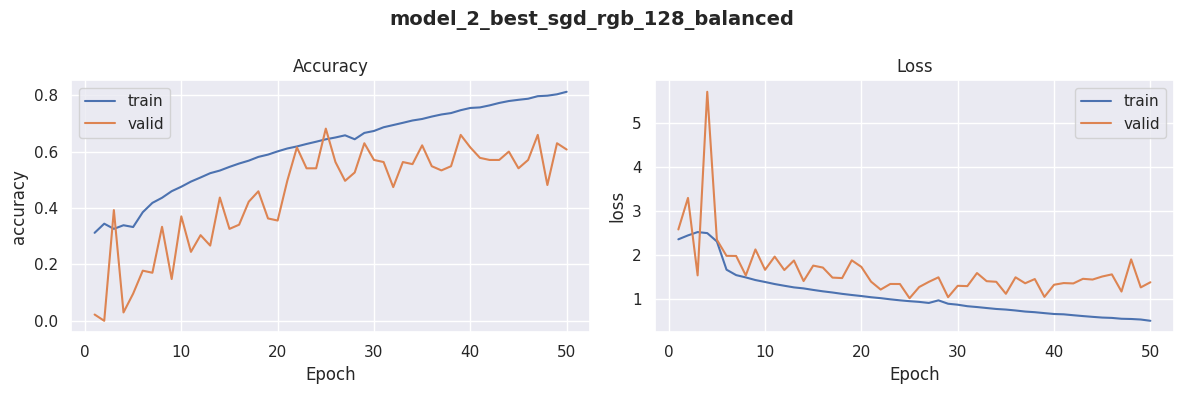

In [13]:

sns.set()
fig = plt.figure(0, (12, 4))

plt.suptitle(model_name,weight='bold', fontsize=14)

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=df.index, y=df['accuracy'], label='train')
sns.lineplot(x=df.index, y=df['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=df.index, y=df['loss'], label='train')
sns.lineplot(x=df.index, y=df['val_loss'], label='valid')
plt.title('Loss')
plt.xlabel('Epoch')
plt.tight_layout()

plt.savefig('../images/best_model_metrics_balanced.png')
plt.show()

<Figure size 1500x500 with 0 Axes>

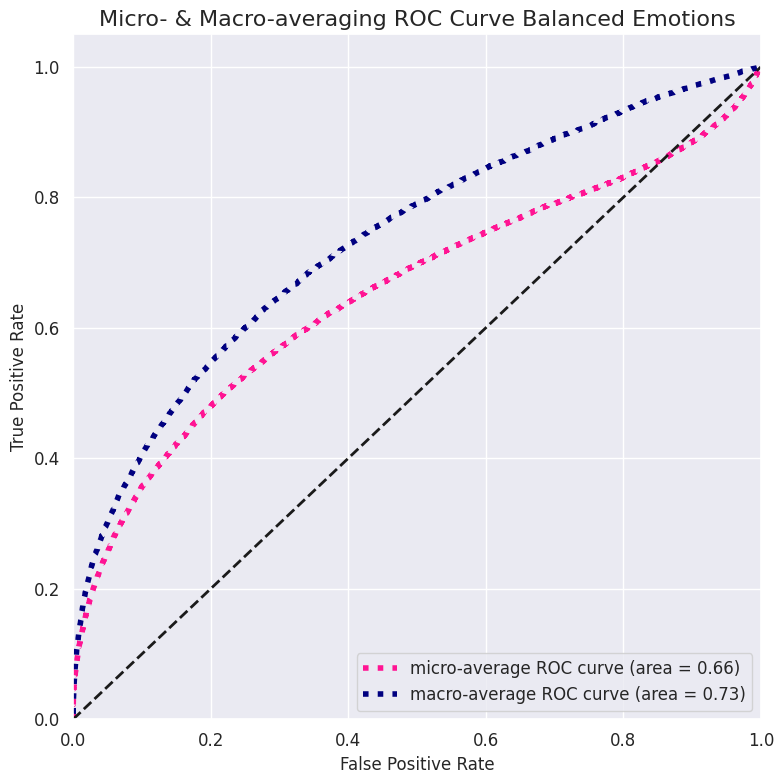

In [14]:
import scikitplot as skplt

# Plot ROC curve
sns.set()
plt.figure(0, (15, 5))

skplt.metrics.plot_roc(
    y_test,  # True labels (in one-hot encoded form)
    y_pred_prob,  # Predicted probabilities
    figsize=(8, 8),
    title='Micro- & Macro-averaging ROC Curve Balanced Emotions',
    plot_micro=True,
    plot_macro=True,
    classes_to_plot=labels.values(),  # Display ROC curves for each class
    cmap='nipy_spectral',
    title_fontsize=16,
    text_fontsize=12
)
plt.tight_layout()
plt.savefig("../images/roc_curve_best_model_balanced.png")
plt.show()

In [15]:
keras_best_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

print("Evaluating train_set ...")
train_loss, train_accuracy = keras_best_model.evaluate(train_set)
print("Evaluating test_set ...")
test_loss, test_accuracy   = keras_best_model.evaluate(test_set)
print("")
print("Final Results by evaluating model (batchsize = 1):")
print("Train accuracy = {:.2f}%".format(train_accuracy * 100))
print("Validation accuracy = {:.2f}%".format(test_accuracy * 100))

Evaluating train_set ...
1641/1641 [==============================] - 59s 35ms/step - loss: 2.8482 - accuracy: 0.4984
Evaluating test_set ...
17326/17326 [==============================] - 34s 2ms/step - loss: 4.1767 - accuracy: 0.3582

Final Results by evaluating model (batchsize = 1):
Train accuracy = 49.84%
Validation accuracy = 35.82%
